# install important libraries and frameworks the we may use

In [ ]:
!pip install opencv-contrib-python

## import any needed libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import zipfile
from os import path, getcwd, chdir
import PIL
import PIL.Image
from keras.models import load_model
import h5py
import pathlib
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import zipfile
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import sklearn
from tqdm import tqdm

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import  layers

## Load data and unzip them

In [ ]:
from zipfile import ZipFile
file_name = "/content/rescaled data.zip"

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()
    print('Done')


Done




---



---



In [ ]:

base_dir ='/content/rescaled data/'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'valid')

train_melanoma_dir = os.path.join(train_dir,'melanoma')
train_nevus_dir = os.path.join(train_dir,'nevus')
train_seborrheic_keratosis_dir = os.path.join(train_dir,'seborrheic_keratosis')


valid_melanoma_dir = os.path.join(validation_dir,'melanoma')
valid_nevus_dir = os.path.join(validation_dir,'nevus')
valid_seborrheic_keratosis_dir = os.path.join(validation_dir,'seborrheic_keratosis')


num_melanoma_training = len(os.listdir(train_melanoma_dir))
num_nevus_training = len(os.listdir(train_nevus_dir))
num_seborrheic_keratosis_training = len(os.listdir(train_seborrheic_keratosis_dir))


num_melanoma_valid= len(os.listdir(valid_melanoma_dir))
num_nevus_valid = len(os.listdir(valid_nevus_dir))
num_seborrheic_keratosis_valid = len(os.listdir(valid_seborrheic_keratosis_dir))




total_training = num_melanoma_training + num_nevus_training + num_seborrheic_keratosis_training
total_validation = num_melanoma_valid + num_nevus_valid + num_seborrheic_keratosis_valid

print('total training melanoma images:', num_melanoma_training)
print('total training nevus images:', num_nevus_training)
print('total training seborrheic keratosis images:', num_seborrheic_keratosis_training)
print("--")

print('total validation melanoma images:', num_melanoma_valid)
print('total validation nevus images:', num_nevus_valid)
print('total validation seborrheic keratosis images:', num_seborrheic_keratosis_valid)
print("--")

print("Total training images:", total_training)
print("Total validation images:", total_validation)


total training melanoma images: 374
total training nevus images: 1372
total training seborrheic keratosis images: 254
--
total validation melanoma images: 30
total validation nevus images: 78
total validation seborrheic keratosis images: 42
--
Total training images: 2000
Total validation images: 150


In [ ]:

train_examples = total_training
validation_examples = total_validation

img_height = img_size =img_width = 150
batch_size = 32


# Create an instance of the inception model from the local pre-trained weights
base_model = tf.keras.applications.Xception(input_shape=(150,150,3),
    include_top=False,
    weights="imagenet"
)

# base_model.load_weights(local_weights_file)

for layer in base_model.layers:
    layer.trainable = True

# # last_layer = base_model.get_layer('mixed7')
# print('last layer output shape: ', last_layer.output_shape)
last_output = base_model.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024,activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256,activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a fully connected layer with 64 hidden units and ReLU activation
x = layers.Dense(64,activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)

model = Model( base_model.input, x)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["acc"])

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=40,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  )

# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(150,150)
                                                   )

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  valid_datagen.flow_from_directory(validation_dir,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(150,150)
                                                   )

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
start_time = time.time()

history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=1
)
end_time = time.time()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
32/32 [==============================] - 24s 576ms/step - loss: 1.1283 - acc: 0.5760 - val_loss: 1.2874 - val_acc: 0.5200
Epoch 2/50
32/32 [==============================] - 18s 546ms/step - loss: 0.9169 - acc: 0.6295 - val_loss: 1.2218 - val_acc: 0.5200
Epoch 3/50
32/32 [==============================] - 18s 556ms/step - loss: 0.8340 - acc: 0.6545 - val_loss: 1.0660 - val_acc: 0.5200
Epoch 4/50
32/32 [==============================] - 19s 577ms/step - loss: 0.7917 - acc: 0.6735 - val_loss: 1.1493 - val_acc: 0.5200
Epoch 5/50
32/32 [==============================] - 19s 568ms/step - loss: 0.7756 - acc: 0.6860 - val_loss: 0.9748 - val_acc: 0.5200
Epoch 6/50
32/32 [==============================] - 19s 574ms/step - loss: 0.7468 - acc: 0.6785 - val_loss: 0.8853 - val_acc: 0.5267
Epoch 7/50
32/32 [==============================] - 19s 570ms/step - loss: 0.7096 - acc: 0.6905 - val_loss: 0.9224 - val_acc: 0.5267
Epoch 8/50
32/32 [==============================] - 19s 571ms/step - 

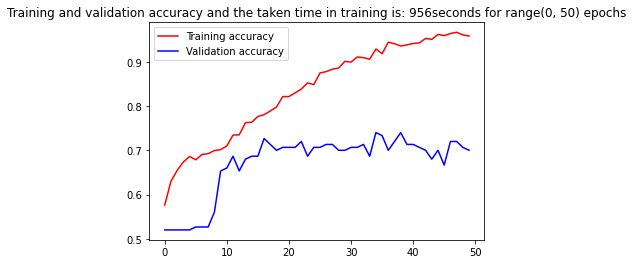

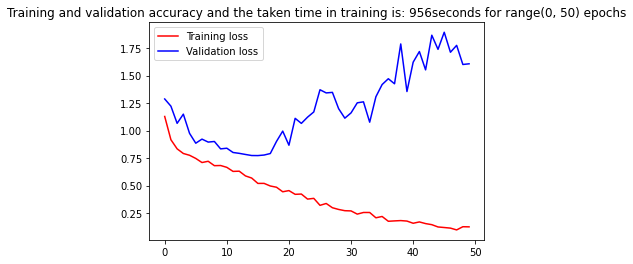

In [ ]:

time_taken = end_time - start_time

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy and the taken time in training is: ' + str(int(time_taken)) + "seconds for " +str(epochs) + " epochs" )
plt.legend(loc=0)
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy and the taken time in training is: ' + str(int(time_taken)) + "seconds for " +str(epochs) + " epochs" )
plt.legend(loc=0)
plt.show()

In [ ]:
export_path_sm = "./models/{}.h5".format("skin_cancer_using_inception_v3_weights")
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./models/skin_cancer_using_inception_v3_weights.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./models/skin_cancer_using_inception_v3_weights.h5/assets


In [ ]:
# from google.colab import files
# files.download("/content/models")

!zip -r '/content/models.zip' '/content/models/'

from google.colab import files

files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/skin_cancer_using_inception_v3_weights.h5/ (stored 0%)
  adding: content/models/skin_cancer_using_inception_v3_weights.h5/variables/ (stored 0%)
  adding: content/models/skin_cancer_using_inception_v3_weights.h5/variables/variables.index (deflated 80%)
  adding: content/models/skin_cancer_using_inception_v3_weights.h5/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/models/skin_cancer_using_inception_v3_weights.h5/assets/ (stored 0%)
  adding: content/models/skin_cancer_using_inception_v3_weights.h5/saved_model.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>